# Google Landmarks Classifier with ResNet50

The following code trains a CNN of type ResNet50 to recognize 20 landmarks in images. There are two models in this notebook:

*   *Landmark_Classifier* uses the pretrained convolutional layers from ResNet and is only trained on the fully connected layers (which don't belong to ResNet, but have been redefined).
*   *Landmark_Classifier_Finetuned* trains both on the ResNet convolutional layers and on the redefined fully connected ones.

The second classifier outperforms the first one by a very large margin.


In [0]:
# Import TensorFlow and print version
#%tensorflow_version 2.x
%tensorflow_version 1.x 
# problems of compatibility between keras and tf version 2.x
import tensorflow as tf

In [0]:
# Import libraries
import pandas as pd
import numpy as np
import io, os
import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

Using TensorFlow backend.


In [0]:
# If running on TPU, run this
#if 'COLAB_TPU_ADDR' not in os.environ: 
#  print('Not connected to TPU') 
#else: 
#  print("Connected to TPU") 

# If running on GPU, run this
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive 
drive.mount('/mntDrive') 
# You need to follow the link and copy the code

Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).


In [0]:
# Is everything we need in the right place?
# I have here the csv-file, the notebook and the folders with train and test pictures
! ls "/mntDrive/My Drive/Landmarks_Colab"

Landmark_Classifier		test
Landmark_Classifier_Finetuned	train
Landmarks_Colab_ResNet50.ipynb	train_label_to_category.gsheet


In [0]:
# Change the working directory
os.chdir('/mntDrive/My Drive/Landmarks_Colab')

In [0]:
# Show the working directory. It should be /mntDrive/My Drive/Landmarks_Colab
!pwd

/mntDrive/My Drive/Landmarks_Colab


In [0]:
# Show content of the working directory. It should now be the same as the output of the previous !ls
!ls

Landmark_Classifier		test
Landmark_Classifier_Finetuned	train
Landmarks_Colab_ResNet50.ipynb	train_label_to_category.gsheet


# Data Preprocessing

In [0]:
# Get the class labels (= names of landmarks = names of subdirectories in /train)
os.chdir('./train/images_resized') # get into the directory with training image folders
labels = glob.glob('*') # get names of all current subfolders
for lab in labels:
  print(lab)
os.chdir('..') # change directory back
os.chdir('..')

# Save number of classes
num_classes = len(labels) # 20
print(num_classes)

Delta_do_Parnaba
Brandenburg_Gate_Berlin
Castle_of_Palma
Grand_Canyon
Eiffel_Tower
Burj_Khalifa
Burj_Al_Arab
Brandenburg_Gate_Potsdam
Basilica_of_the_Sacred_Heart
Atomium
Great_Sphinx_of_Giza
Niagara_Falls
Westminster_Abbey
Sphinx_of_Memphis
Great_Pyramid_of_Giza
Great_Wall_of_China
Water_of_Girvan
Machu_Picchu
Great_Barrier_Reef
Sydney_Opera_House
20


In [0]:
# Get paths to training images
train_paths = []
for lab in labels:
  path = './train/images_resized/' + lab + '/*.jpg' # links to all images per landmark
  train_paths.append(glob.glob(path))
  print(lab + ' training images: ' + str(len(train_paths[len(train_paths)-1]))) # last index = current length-1

print(len(train_paths))

Delta_do_Parnaba training images: 90
Brandenburg_Gate_Berlin training images: 87
Castle_of_Palma training images: 36
Grand_Canyon training images: 52
Eiffel_Tower training images: 90
Burj_Khalifa training images: 20
Burj_Al_Arab training images: 19
Brandenburg_Gate_Potsdam training images: 57
Basilica_of_the_Sacred_Heart training images: 61
Atomium training images: 90
Great_Sphinx_of_Giza training images: 58
Niagara_Falls training images: 87
Westminster_Abbey training images: 76
Sphinx_of_Memphis training images: 36
Great_Pyramid_of_Giza training images: 80
Great_Wall_of_China training images: 69
Water_of_Girvan training images: 54
Machu_Picchu training images: 90
Great_Barrier_Reef training images: 90
Sydney_Opera_House training images: 90
20


In [0]:
# Get paths to test images
test_paths = []
for lab in labels:
  path = './test/images_resized/' + lab + '/*.jpg' # links to all images per landmark
  test_paths.append(glob.glob(path))
  print(lab + ' test images: ' + str(len(test_paths[len(test_paths)-1]))) # last index = current length-1

print(len(test_paths))

Delta_do_Parnaba test images: 10
Brandenburg_Gate_Berlin test images: 9
Castle_of_Palma test images: 4
Grand_Canyon test images: 6
Eiffel_Tower test images: 10
Burj_Khalifa test images: 2
Burj_Al_Arab test images: 2
Brandenburg_Gate_Potsdam test images: 6
Basilica_of_the_Sacred_Heart test images: 6
Atomium test images: 10
Great_Sphinx_of_Giza test images: 6
Niagara_Falls test images: 10
Westminster_Abbey test images: 8
Sphinx_of_Memphis test images: 4
Great_Pyramid_of_Giza test images: 8
Great_Wall_of_China test images: 7
Water_of_Girvan test images: 5
Machu_Picchu test images: 10
Great_Barrier_Reef test images: 10
Sydney_Opera_House test images: 10
20


In [0]:
# Define new dimensions for all images (if not already resized)
from keras.utils import to_categorical # for one-hot-encoding labels
img_width  = 300
img_height = 300
img_dim = (img_width, img_height)

In [0]:
# Load training and test images and resize them (if not already resized)
train_imgs = [img_to_array(load_img(img, target_size=img_dim)) for folder in train_paths for img in folder]
#train_imgs = [img_to_array(load_img(img)) for folder in train_paths for img in folder]
train_imgs = np.array(train_imgs)
print(f"Training images: {len(train_imgs)}") # 1332

test_imgs = [img_to_array(load_img(img, target_size=img_dim)) for folder in test_paths for img in folder]
#test_imgs = [img_to_array(load_img(img)) for folder in test_paths for img in folder]
test_imgs = np.array(test_imgs)
print(f"Test images: {len(test_imgs)}") # 143

Training images: 1332
Test images: 143


In [0]:
# Define vectors of labels (size = total number of training/test images)
train_labels = []
test_labels  = [] 
for i in range(num_classes):
  train_labels += [i] * len(train_paths[i])
  test_labels  += [i] * len(test_paths[i])

print(train_labels)
print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [0]:
# One-hot encoding for the label vectors
train_labels = to_categorical(train_labels)    
print(train_labels.shape)  
print(train_labels)
test_labels = to_categorical(test_labels)
print(test_labels.shape)
print(test_labels)

(1332, 20)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(143, 20)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


(300, 300, 3)


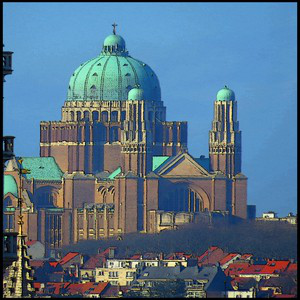

In [0]:
# Visualize a sample image 
print(train_imgs[500].shape) 
array_to_img(train_imgs[500])

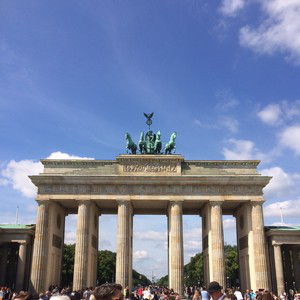

In [0]:
array_to_img(test_imgs[10])

In [0]:
# Data augmentation (only on training set)
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.3, rotation_range = 50,
                                   width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, 
                                   horizontal_flip = True, fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)

Labels: [array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)]
5


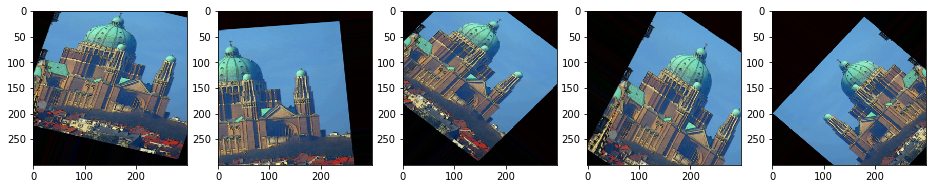

In [0]:
# Sample of transformed image
img_id = 500
atom_generator = train_datagen.flow(train_imgs[img_id : img_id+1], 
                                    train_labels[img_id : img_id+1], 
                                    batch_size = 1) 
atom = [next(atom_generator) for i in range(0, 5)] 
fig, ax = plt.subplots(1, 5, figsize = (16, 6))
print('Labels:', [item[1][0] for item in atom]) 
l = [ax[i].imshow(atom[i][0][0]) for i in range(0, 5)]
print(len(atom)) # 5

In [0]:
# Apply transformations on whole training and test set
train_generator = train_datagen.flow(train_imgs, train_labels, batch_size = 10) # 30 was too big -> couldn't train all conv. params.
test_generator  = test_datagen.flow(test_imgs, test_labels, batch_size = 1)

In [0]:
print(test_generator[0][0][0])

# Model fitting

Import convolutional layers from ResNet50

In [0]:
# Transfer learning using pre-trained ResNet50 as Feature Extractor
from keras.applications.resnet import ResNet50
from keras.models import Model
import keras

In [0]:
input_shape = (img_height, img_width, 3)
resnet = ResNet50(include_top = False, # remove last prediction layer from ResNet (we'll replace it with our own hidden layers)
                  weights = 'imagenet', 
                  input_shape = input_shape)
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(resnet.input, output=output)

In [0]:
# Freeze the weights in the pretrained model, so that they don't get updated during training
for layer in resnet.layers:
    layer.trainable = False

resnet.summary() # over 23M parameters (frozen)

In [0]:
# Add your own fully connected layer to the pretrained model 
# and the final classifier 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import optimizers

Model 1: train only the hidden layers

In [0]:
# Initialize the model
model = Sequential()

In [0]:
# Add pretrained network to the model
model.add(resnet)

# Hidden layers
model.add(Dense(512, activation='relu', input_dim = input_shape)) 
model.add(Dropout(0.25))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(num_classes, activation = 'sigmoid')) 

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-5),
              metrics = ['accuracy'])

model.summary() # over 105M parameters (trainable)

In [0]:
# Compile this, if you want to load the weights you trained last time
model.load_weights('Landmark_Classifier')

In [0]:
# Run the model
history = model.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator),
                              epochs = 10,
                              validation_data = test_generator,
                              validation_steps = len(test_generator),
                              verbose = 1)

Epoch 1/10
134/134 [==============================] - 36s 267ms/step - loss: 2.9309 - acc: 0.1157 - val_loss: 3.0445 - val_acc: 0.0699
Epoch 2/10
134/134 [==============================] - 29s 216ms/step - loss: 2.5820 - acc: 0.2649 - val_loss: 3.2194 - val_acc: 0.0559
Epoch 3/10
134/134 [==============================] - 30s 227ms/step - loss: 2.2869 - acc: 0.3769 - val_loss: 3.3078 - val_acc: 0.0559
Epoch 4/10
134/134 [==============================] - 29s 217ms/step - loss: 2.0586 - acc: 0.4545 - val_loss: 3.4602 - val_acc: 0.0559
Epoch 5/10
134/134 [==============================] - 29s 220ms/step - loss: 1.9369 - acc: 0.4784 - val_loss: 3.4166 - val_acc: 0.0769
Epoch 6/10
134/134 [==============================] - 29s 219ms/step - loss: 1.8020 - acc: 0.5291 - val_loss: 3.3767 - val_acc: 0.0559
Epoch 7/10
134/134 [==============================] - 30s 222ms/step - loss: 1.6307 - acc: 0.5582 - val_loss: 3.5219 - val_acc: 0.0629
Epoch 8/10
134/134 [==============================] - 2

In [0]:
# Save the trained weights
model.save('Landmark_Classifier')

Model 2: train convolutional parameters, as well

In [0]:
# Fine-tune the pretrained model by unfreezing the last conv. blocks
for layer in resnet.layers:
    layer.trainable = True

In [0]:
# Initialize model
model_finetuned = Sequential()

In [0]:
# Define architecture
model_finetuned.add(resnet)
model_finetuned.add(Dense(512, activation='relu', input_dim = input_shape))
model_finetuned.add(Dropout(0.25))
model_finetuned.add(Dense(512, activation = 'relu'))
model_finetuned.add(Dropout(0.25))
model_finetuned.add(Dense(num_classes, activation = 'sigmoid'))
model_finetuned.compile(loss = 'categorical_crossentropy',
                        optimizer = optimizers.RMSprop(lr = 1e-5),
                        metrics = ['accuracy'])
model_finetuned.summary() # over 128M trainable params

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                10260     
Tot

In [0]:
# # Compile this, if you want to load the weights you trained last time
model_finetuned.load_weights('Landmark_Classifier_Finetuned')

In [0]:
# Run the model
history = model_finetuned.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator),
                              epochs = 30,
                              validation_data = test_generator,
                              validation_steps = len(test_generator),
                              verbose = 1)

Epoch 1/30
134/134 [==============================] - 62s 461ms/step - loss: 2.9374 - acc: 0.1052 - val_loss: 2.3629 - val_acc: 0.3147
Epoch 2/30
134/134 [==============================] - 45s 338ms/step - loss: 2.4850 - acc: 0.2739 - val_loss: 1.5749 - val_acc: 0.6364
Epoch 3/30
134/134 [==============================] - 45s 339ms/step - loss: 2.1244 - acc: 0.4149 - val_loss: 1.1572 - val_acc: 0.7483
Epoch 4/30
134/134 [==============================] - 45s 338ms/step - loss: 1.9403 - acc: 0.4925 - val_loss: 0.8884 - val_acc: 0.7762
Epoch 5/30
134/134 [==============================] - 45s 337ms/step - loss: 1.7451 - acc: 0.5545 - val_loss: 0.8056 - val_acc: 0.8112
Epoch 6/30
134/134 [==============================] - 45s 338ms/step - loss: 1.5343 - acc: 0.5985 - val_loss: 0.7055 - val_acc: 0.8252
Epoch 7/30
134/134 [==============================] - 45s 338ms/step - loss: 1.4308 - acc: 0.6291 - val_loss: 0.5719 - val_acc: 0.8601
Epoch 8/30
134/134 [==============================] - 4

In [0]:
# Save the trained weights
model_finetuned.save('Landmark_Classifier_Finetuned')  

# Evaluation

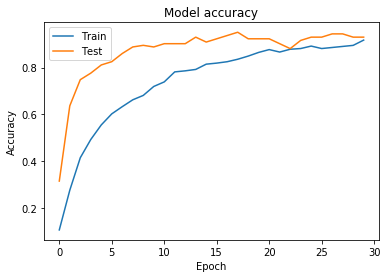

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [0]:
# Make predictions
prob_matrix = model_finetuned.predict(test_imgs/255) # divide by 255 just like in the data augm. to avoid getting all-zero-predictions

In [0]:
print(prob_matrix) # 143 x 20 matrix of probabilities

[[9.3028647e-01 2.5928020e-06 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.2427568e-05]
 [9.9999952e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [9.9997526e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 7.3322749e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.7222295e-01]]


In [0]:
# Build vectors of true labels and predictions
predictions = []
true_labels = []
for row in prob_matrix:
  predictions.append(np.where(row == np.amax(row))[0][0])

for i in range(num_classes):
  true_labels  += [i] * len(test_paths[i])

# Compare true classes to predicted classes and identify the wrong predictions
print(predictions)
print(true_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 12, 4, 4, 5, 5, 4, 19, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 14, 10, 10, 11, 11, 11, 11, 11, 3, 17, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 0, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 0, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 19, 19, 19, 19, 19, 19, 0, 19, 19, 19]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19

In [0]:
# Get indices of wrongly classified landmarks
wrong_ind = np.where(np.equal(predictions, true_labels) == False)[0]

print(wrong_ind)

[ 36  41  42  68  76  77 100 119 132 139]


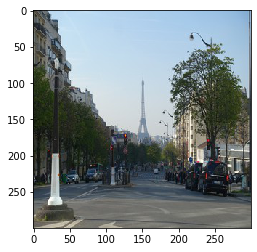

True class: Eiffel_Tower
Prediction: Westminster_Abbey
 


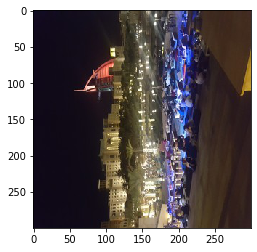

True class: Burj_Al_Arab
Prediction: Eiffel_Tower
 


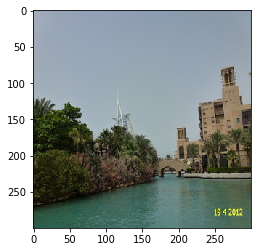

True class: Burj_Al_Arab
Prediction: Sydney_Opera_House
 


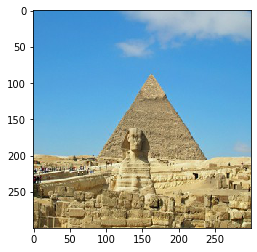

True class: Great_Sphinx_of_Giza
Prediction: Great_Pyramid_of_Giza
 


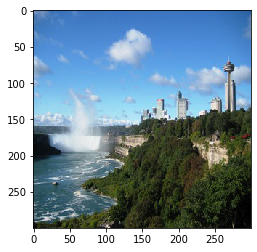

True class: Niagara_Falls
Prediction: Grand_Canyon
 


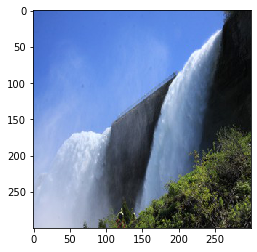

True class: Niagara_Falls
Prediction: Machu_Picchu
 


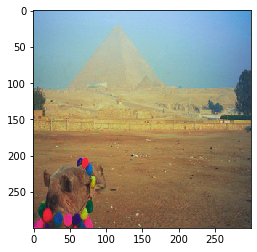

True class: Great_Pyramid_of_Giza
Prediction: Delta_do_Parnaba
 


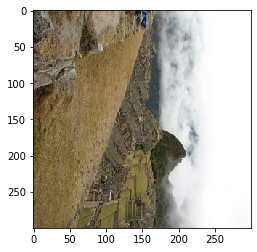

True class: Machu_Picchu
Prediction: Delta_do_Parnaba
 


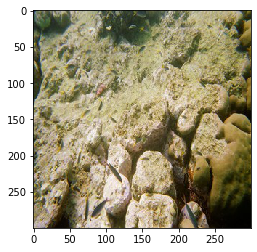

True class: Great_Barrier_Reef
Prediction: Machu_Picchu
 


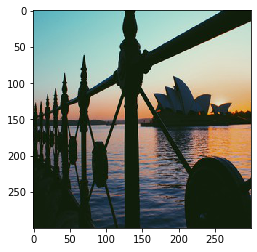

True class: Sydney_Opera_House
Prediction: Delta_do_Parnaba
 


In [0]:
# Visualize wrong predictions
for i in range(len(wrong_ind)):
  plt.imshow(test_imgs[wrong_ind[i]]/255)
  plt.show()
  print(f"True class: {labels[true_labels[wrong_ind[i]]]}")
  print(f"Prediction: {labels[predictions[wrong_ind[i]]]}")
  print(" ")